# Training Set

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.externals import joblib
%matplotlib inline   

In [2]:
#import os
#os.system('cp /home/wolfm2/job.sh .; echo test 1>&2') #; cp ../job.log ../jerbb.txt')

### Read raw training data

In [3]:
amazon = pd.read_csv('/home/wolfm2/amazon_data/raw_data_train.csv')
print(amazon.shape)

(364000, 14)


In [4]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      150581        487850  487851  B0025UCD76  A28B2M0XRXHXIG   
1      334018         21518   21519  B002QWP89S   A7JJX3KMDZD2F   
2       76657        319457  319458  B001GVIUX6  A2S8RJ6DRKGYON   
3      357903        248851  248852  B0009JRH1C  A1FLQ698D9C0C8   
4      301824        394613  394614  B001B4VOQI  A2KJO9EPX17ZXE   

                   ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  \
0                         B622                     0                       0   
1  Shinichi Isozaki "shincyan"                     1                       2   
2                   M. Ronning                     1                       2   
3                     G. Zhang                     4                       8   
4                    Musical E                     0                       0   

   Score        Time                                            Summary  \
0      5  1313020800                     

### Feature extraction on natural language data

In [5]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [6]:
# import nltk
# nltk.download('punkt')
# nltk.download('popular')

#from nltk import word_tokenize          
#from nltk.stem import WordNetLemmatizer 

#class LemmaTokenizer(object):
#     def __init__(self):
#         self.wnl = WordNetLemmatizer()
#     def __call__(self, doc):
#         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [7]:
# vectorize Bag of Words from review text; as sparse matrix
from sklearn.feature_extraction.text import HashingVectorizer
#hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
# tokenizer=LemmaTokenizer(),  analyzer=stemmed_words, stop_words={'english'}, 
hv = HashingVectorizer(n_features=2 ** 19, non_negative=True, strip_accents=ascii, 
                           ngram_range=(1,4), token_pattern = r'\b[a-zA-Z]{3,}\b')
X_hv = hv.fit_transform(amazon.Text)
print(X_hv.shape)

/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(364000, 524288)


In [8]:
# We want to be able to use this model fit on other data (the test set)
# So let's save a copy of this instance of HashingVectorizer to be able to transform other data with this fit
# http://scikit-learn.org/stable/modules/model_persistence.html
joblib.dump(hv, 'hv.pkl') # pickle

['hv.pkl']

In [9]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X_hv)

joblib.dump(transformer, 'transformer.pkl') # pickle

['transformer.pkl']

In [10]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [11]:
# features from Amazon.csv to add to feature set
amazon['reviewLen'] = amazon['Text'].str.len()

X_quant_features = amazon[["Score", "reviewLen"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   Score  reviewLen
0      5        110
1      5        140
2      2        471
3      5      10800
4      5        152
5      4        231
6      5        271
7      5        320
8      2        362
9      5        283
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [12]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(364000, 524290)


### Create `X`, scaled matrix of features

In [13]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_matrix)
print(X.shape)

joblib.dump(sc, 'sc.pkl') # pickle

(364000, 524290)


['sc.pkl']

### create `y`, vector of Labels

In [14]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### fit models

In [15]:
from my_measures import BinaryClassificationPerformance

In [16]:
# MODEL: SVM, linear
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X, y)
joblib.dump(svm, 'svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


{'Pos': 26647, 'Neg': 337353, 'TP': 26223, 'TN': 336683, 'FP': 670, 'FN': 424, 'Accuracy': 0.99699450549450552, 'Precision': 0.97508645372401737, 'Recall': 0.98408826509550795, 'desc': 'svm'}


In [17]:
# MODEL: logistic regression
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
lgs.fit(X, y)
joblib.dump(lgs, 'lgs.pkl') # pickle

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


{'Pos': 26647, 'Neg': 337353, 'TP': 26467, 'TN': 337209, 'FP': 144, 'FN': 180, 'Accuracy': 0.99910989010989015, 'Precision': 0.99458870391943177, 'Recall': 0.99324501820092315, 'desc': 'lgs'}


In [18]:
# MODEL: Naive Bayes
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X, y)
joblib.dump(nbs, 'nbs.pkl') # pickle

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 26647, 'Neg': 337353, 'TP': 23383, 'TN': 330226, 'FP': 7127, 'FN': 3264, 'Accuracy': 0.97145329670329672, 'Precision': 0.76640445755490005, 'Recall': 0.8775096633767403, 'desc': 'nbs'}


In [19]:
# MODEL: Ridge Regression Classifier
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X, y)
joblib.dump(rdg, 'rdg.pkl') # pickle

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 26647, 'Neg': 337353, 'TP': 26463, 'TN': 337274, 'FP': 79, 'FN': 184, 'Accuracy': 0.99927747252747257, 'Precision': 0.99702358526109558, 'Recall': 0.99309490749427698, 'desc': 'rdg'}


In [20]:
# MODEL: Perceptron
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X, y)
joblib.dump(prc, 'prc.pkl') # pickle

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


{'Pos': 26647, 'Neg': 337353, 'TP': 26211, 'TN': 336668, 'FP': 685, 'FN': 436, 'Accuracy': 0.99692032967032962, 'Precision': 0.97453152885187388, 'Recall': 0.98363793297556945, 'desc': 'prc'}


In [21]:
# import json
# import datetime
# import numpy as np
# from sklearn.model_selection import GridSearchCV
# from sklearn import linear_model
# from sklearn.naive_bayes import MultinomialNB

# # prepare a range of alpha values to test
# # alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
# alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0.00001])
# # create and fit a ridge regression model, testing each alpha
# # model = linear_model.SGDClassifier(loss='perceptron', max_iter=50) # max_iter 1000

# svm = linear_model.SGDClassifier(n_iter=500)
# lgs = linear_model.SGDClassifier(loss='log', n_iter=500)
# nbs = MultinomialNB()
# rdg = linear_model.RidgeClassifier()
# prc = linear_model.SGDClassifier(loss='perceptron', n_iter=500)

# for model in [svm, lgs, prc, nbs, rdg]: 
# # for model in [rdg]:    
#   fh = open("GridSearch.txt", "a")
#   grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas)) # n_jobs
#   grid.fit(X, y)
#   print(grid)
#   # summarize the results of the grid search
#   print(grid.cv_results_)
#   print(grid.best_score_)
#   print(grid.best_estimator_.alpha)

#   fh.write('\n########\n')
#   fh.write(str(datetime.datetime.now()))
#   fh.write('\n########\n')
#   fh.write(str(model) + '\n')  
#   fh.write(str(grid.cv_results_).replace(", '", ",\n'") + '\n')
#   fh.write(str(grid.best_score_) + '\n')  
#   fh.write(str(grid.best_estimator_.alpha) + '\n')
#   fh.close()

### ROC plot to compare performance of various models and fits

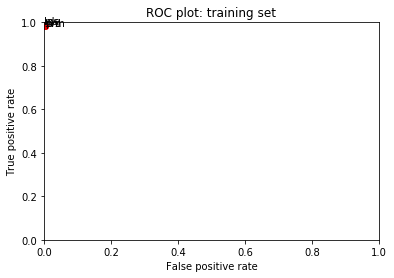

In [22]:
#fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance]
fits = [svm_performance, lgs_performance, rdg_performance, prc_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()